<div class="alert alert-info">
Приветствую, Кирилл!
    
Не совсем разорался как оформлять, поэтому сделал как понял: начал анализ данных, а план в самом низу накидал [(получилось 3м пунктом)](#1-bullet)
    
</div>

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
    <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
<font color='green'><br>
<br />
Дмитрий, доброго дня! рад приветствовать тебя в финале) <br />
Вот и он подобрался, поздравляю. Остался последний рывок в этом марафоне)<br>
<br />    
Несмотря на то, что проект не такой уж и простой как с позиции кода, так и в понимании процессов - <br />тебе удалось сдать его вовремя, это большой плюс для всех нас, спасибо:)<br />
<br />
Меня зовут Николай. <br />И на этом этапе Вашего движения к новой профессии от меня будут комментарии по написанному коду. <br />Чтобы меньше "мусорить эфир" и чтобы максимально наглядно отделяться от основного кода, есть предложение условиться в некоторых обозначениях:<br /> <br />
<u><b>ТАКОЙ ШРИФТ</b></u> - всегда начало комментария <br />
<font color='green'>такой шрифт</font> - комментарии о том, что всё ОК <br/>
<font color='purple'>такой шрифт</font> - комментарии о том, что всё ОК по результату,<br> однако что есть ещё что-то или в коде или есть способы сделать более короткий или быстрый код <br/>
<font color='red'>такой шрифт</font> - комментарии о том, что есть критичный момент, влияющий на бизнес-результат проекта.<br/>
</font><br /><br />
<font color='green'>Как и всегда в спринтах - ставлю своей целью максимально помочь. Поэтому, все мои комментарии - это только способ передать свой опыт для помощи в твоих достижениях.
    </div>

<div class="alert alert-info">
Доброго дня, Николай!
    
Спасибо за ревью! [Доработки в конце](#2-bullet)
    
</div>

# Промышленность ООО «Так закаляем сталь»

## Вводная часть

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

<a id='1-bullet'></a>

## План действий
* Нам надо прогнозировать температуру на конец каждой партии
* План:
    1. Предобработка данных
        1. Работа с пропусками (что-то на нули заменим согласно описанию выше)
        2. Посмотреть гистограммы распределения, ящики с усами, поработать с выбивающимися значениями
        3. Посмотреть партии, у которых пропуски конечной температуры и наверное дропнуть их
        4. Пересчитать полную мощность в подведененую энергию (умножением на время и сложением) для каждой партии
        5. Сагрегировать таблицу признаков: `номер партии`, `начальная Т`, `энергия`, набор столбцов с кол-вом сыпучих и проволочных материалов, `конечная Т`(целевой признак)
        6. Поделим на трейн и тест как 3:1
    2. Модель
        1. Проверка на мультиколинеарность
        2. Обучить и протестировать модели LinearRegression, RandomForestRegressor
        3. Проверка качества в сравнении с дамми моделью
    3. Общий вывод

## Анализ данных

### Подгрузим библиотеки и данные

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.model_selection import cross_val_score
import seaborn as sns
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [2]:
df_dict = {'data_arc': [],
           'data_bulk': [],
           'data_bulk_time': [],
           'data_gas': [],
           'data_temp': [],
           'data_wire': [],
           'data_wire_time': []    
}

for df in df_dict:
    df_dict[df] = pd.read_csv('/datasets/final_steel/' + df + '.csv')

In [3]:
for df in df_dict:
    print(df)
    print(df_dict[df].info())
    display(df_dict[df])
    display(df_dict[df].describe())

data_arc
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


data_bulk
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


data_bulk_time
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


data_gas
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


data_temp
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
None


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


data_wire
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


data_wire_time
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


* Данные представляют из себя 7 таблиц:
    1. Данные об электродах: 5 столбцов 14876 строк
        * Пропусков нет
        * Начало и конец нагрева можно перевести в дату. Остальные типы соответствуют
        * Реактивная мощность есть отрицательные значения
    2. Данные о подаче сыпучих материалов (объём): 16 столбцов 3129 строк
        * Пропуски во всех столбцах, кроме `key`. В 8м ковше вообще только одно значение
        * 15 ковшей
        * Согласно информации от Тимлида пропуски это отсутствие подачи материала. Значит их можно заменить нулями
    3. Данные о подаче сыпучих материалов (время): 16 столбцов 3129 строк
        * Пропуски полностью совпадают с предыдущей таблицей
    4. Данные о продувке сплава газом: 2 столбца 3239 строк
        * Пропусков нет
    5. Результаты измерения температуры: 3 стобца 15907 строк
        * Пропуски в столбце Температура (13006 непустых). Цифры в порядке
        * Согласно данным от Тимлида пропуски в конце партии - это данные, которые заказчик будет использовать в качестве теста. Видимо придется исключить такие партии
    6. Данные о проволочных материалах (объём): 10 столбцов 3081 строка
        * Пропуски везде, кроме `key`
        * 9 проволок
        * Судя по пропускам в основном используют 1й и 2й материалы
        * Также как и для второй таблицы можно воспользоваться инфо от Тимлида и заменить пропуски на нули
    7. Данные о проволочных материалах (время): 10 столбцов 3081 строка
        * Тут всё логично соответствует предыдущей таблице с объемами

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>ОК, данные на базе) Судя по выводам - внимательно апросмотрены.
    </div>

### Предобработка данных

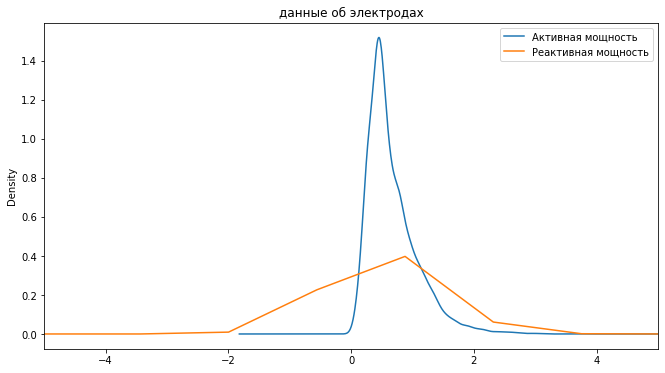

2116


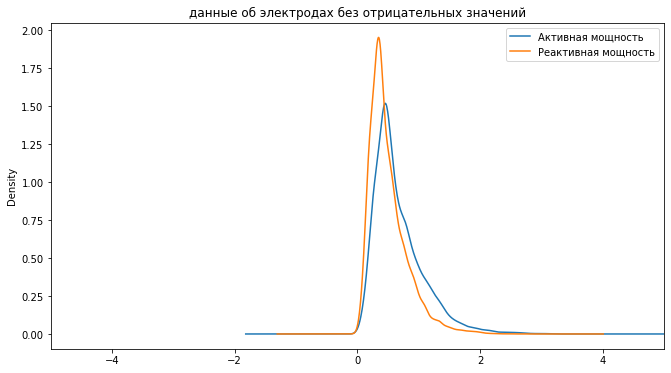

In [4]:
data_arc = df_dict['data_arc'].copy()
data_arc['Активная мощность'].plot(kind='kde',label='Активная мощность')
data_arc['Реактивная мощность'].plot(kind='kde',
                                                title="данные об электродах",
                                                label='Реактивная мощность',
                                                figsize=(11,6))
plt.legend(loc="upper right")
plt.xlim(-5,5)
plt.show()

key_anomal = data_arc[data_arc['Реактивная мощность']<0]
print(key_anomal.values[0][0])
data_arc.drop(data_arc[data_arc['key']==key_anomal.values[0][0]].index, inplace=True)

data_arc['Активная мощность'].plot(kind='kde',label='Активная мощность')
data_arc['Реактивная мощность'].plot(kind='kde',
                                                title="данные об электродах без отрицательных значений",
                                                label='Реактивная мощность',
                                                figsize=(11,6))
plt.legend(loc="upper right")
plt.xlim(-5,5)
plt.show()


* Для активной мощности распределение почти нормальное, смещенное влево
* Для реактивной впринципе тоже, но есть сильно выбивающееся отрицательное значение. Т.к. оно одно лучше его убрать, вместе со всей партией (меньше одного процента данных)
* Действительно без отрицательных значений данные выглядят нормально

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>да, в реактивной - однозначно выброс)
    </div>

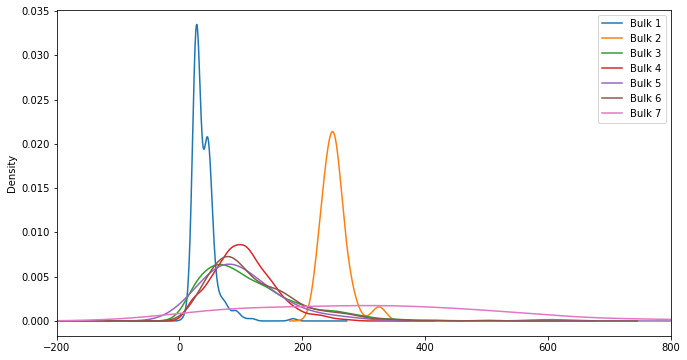

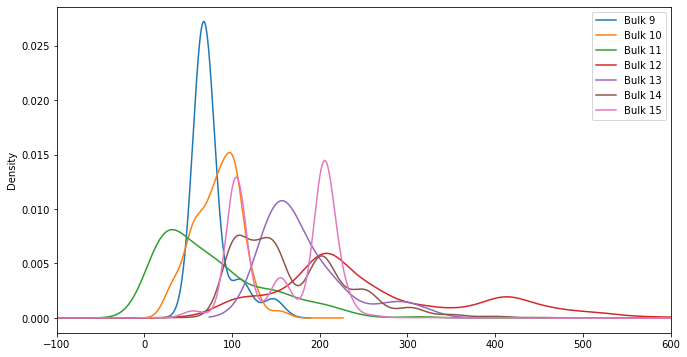

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
1725,1786,NaN,NaN,123.0,NaN,NaN,NaN,NaN,49.0,147.0,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
data_bulk = df_dict['data_bulk'].copy()
plt.rcParams["figure.figsize"] = (11,6)
for bulk_ind in range(1,9):
    if data_bulk['Bulk '+str(bulk_ind)].notna().sum() > 1:
        data_bulk['Bulk '+str(bulk_ind)].plot(kind='kde',label='Bulk '+str(bulk_ind))

plt.legend(loc="upper right", prop={'size': 10}, fontsize=10)
plt.xlim(-200,800)
plt.show()
for bulk_ind in range(9,16):
    if data_bulk['Bulk '+str(bulk_ind)].notna().sum() > 1:
        data_bulk['Bulk '+str(bulk_ind)].plot(kind='kde',label='Bulk '+str(bulk_ind))

plt.legend(loc="upper right", prop={'size': 10}, fontsize=10)
plt.xlim(-100,600)
plt.show()
key_anomal = data_bulk[data_bulk['Bulk 8'].notna()]
display(key_anomal)
data_bulk.drop(data_bulk[data_bulk['key']==key_anomal.values[0][0]].index, inplace=True)

* По `Bulk8` всего лишь одно значение. Такую партию можно считать аномальной и избавиться от нее а заодно и от целого столбца (меньше одного процента)
* По большинству материалов данные выглядят нормально. Есть бимодальные распределения (яркие примеры 14 и 15)

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>ок
    </div>

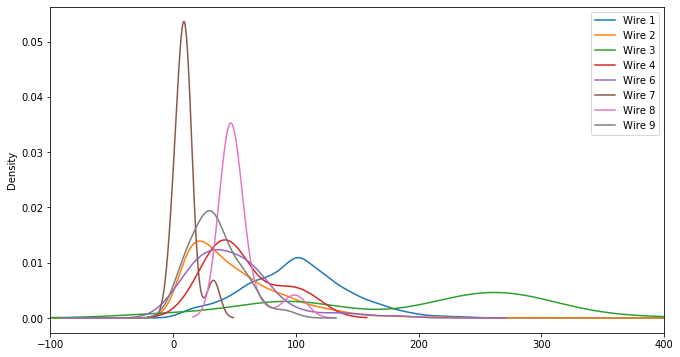

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
2440,2567,18.30192,NaN,96.288193,NaN,15.132,73.307526,NaN,NaN,NaN


In [6]:
data_wire = df_dict['data_wire'].copy()
plt.rcParams["figure.figsize"] = (11,6)
for wire_ind in range(1,10):
    if data_wire['Wire '+str(wire_ind)].notna().sum() > 1:
        data_wire['Wire '+str(wire_ind)].plot(kind='kde',label='Wire '+str(wire_ind))

plt.legend(loc="upper right", prop={'size': 10}, fontsize=10)
plt.xlim(-100,400)
plt.show()
key_anomal = data_wire[data_wire['Wire 5'].notna()]
display(key_anomal)
data_wire.drop(data_wire[data_wire['key']==key_anomal.values[0][0]].index, inplace=True)

* По `Wire 5` всего лишь одно значение. Такая же история как с `Bulk 8 `, считаем аномалией и избавляемся
* Данные выглядят нормально. Есть бимодальные, но не так явно как для сыпучих материалов

### Формирование таблицы для обучения модели

Сформируем таблицу с начальной и конечной температурой для каждой партии, предварительно исквлючив партии с пропусками по температуре

In [7]:
df_temp_count = df_dict['data_temp'].groupby('key').count()
df_temp_count.drop(df_temp_count[df_temp_count['Время замера'] != df_temp_count['Температура']].index, inplace=True)
keys_list = df_temp_count.index.to_list()
df_first_last_temp = pd.pivot_table(df_dict['data_temp'], 
                              values='Температура', 
                              index='key', 
                              aggfunc=['first', 'last'])
df_first_last_temp = df_first_last_temp[df_first_last_temp.index.isin(keys_list)]
df_first_last_temp.columns = ['temp_first', 'temp_last']

Теперь вычислим полную мощность, подведенную энергию и посчитаем энергию дя каждоу партии

In [8]:
data_arc['full_cap'] = (data_arc['Активная мощность'] ** 2 + data_arc['Реактивная мощность'] ** 2) ** 0.5
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'], 
                                                 format='%Y%m%d %H:%M:%S')
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'], 
                                                  format='%Y%m%d %H:%M:%S')
data_arc['heat_time'] = data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']
data_arc['energy'] = data_arc['full_cap'] * data_arc['heat_time'].dt.total_seconds()
data_energy_total = pd.pivot_table(data_arc, index='key', values='energy', aggfunc=np.sum)

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>С поной мощностью - ОК) 
    </div>

Осталось обработать данные по материалам и соединить всё в одну таблицу

In [9]:
df_bulk = data_bulk.fillna(0)
df_wire = data_wire.fillna(0)

df_total = pd.merge(df_first_last_temp, data_energy_total, left_index=True, right_index=True)
df_total = pd.merge(df_total, df_bulk, left_index=True, right_on='key')
df_total = pd.merge(df_total, df_wire, left_on='key', right_on='key')
display(df_total)

,temp_first,temp_last,energy,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1571.0,1613.0,1442.377754,1,0.0,0.0,0.0,43.0,0.0,0.0,...,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1581.0,1602.0,881.233565,2,0.0,0.0,0.0,73.0,0.0,0.0,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1596.0,1599.0,525.066777,3,0.0,0.0,0.0,34.0,0.0,0.0,...,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1601.0,1625.0,796.911309,4,0.0,0.0,0.0,81.0,0.0,0.0,...,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1576.0,1602.0,1199.137958,5,0.0,0.0,0.0,78.0,0.0,0.0,...,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,1570.0,1591.0,778.818234,2495,0.0,0.0,21.0,0.0,0.0,0.0,...,223.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2325,1554.0,1591.0,875.261419,2496,0.0,0.0,0.0,63.0,0.0,0.0,...,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2326,1571.0,1589.0,556.930349,2497,0.0,0.0,0.0,85.0,0.0,0.0,...,226.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2327,1591.0,1594.0,767.817794,2498,0.0,0.0,90.0,0.0,0.0,0.0,...,207.0,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>И верно - нужно исключать партии, где есть пропуск в целевой) Это важный момент проекта. И ты сделал его!
    </div>

## Модель

### Проверка на мультиколинеарность

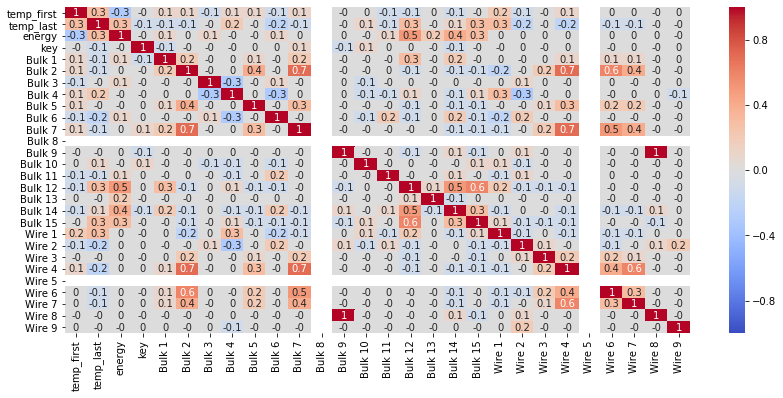

In [10]:
plt.rcParams["figure.figsize"] = (14,6)
sns.heatmap(df_total.corr().round(1), vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', annot=True)
plt.show()

* Всё что ниже 0,8 по модулю не будем отбрасывать. Из таких только пара `Bulk 9` - `Wire 8`
* Какая-то корреляция прослеживается для `Wire 4` с `Bulk 2`, `Bulk 7` и `Wire 7`;
* `Bulk 2` и `Bulk 7`; `Wire 6` и `Bulk 2`

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>да!!! Хорошо, что изучаешь эту проблематику)
    </div>

### Подготовка признаков

* Как описано выше целевой признак конечная температура партии
* Для фичей нужно исключить `Wire 5`, `Wire 8`, `Bulk 8`

In [53]:
features = df_total.drop(columns=['temp_last', 'Wire 5', 'Wire 8', 'Bulk 8', 'key'])
target = df_total['temp_last']
features_train, features_test, target_train, target_test = train_test_split(
        features, target, test_size=0.25, random_state=12345)

### Обучение моделей

Здесь сначала попробуем простые модели - LogisticRegression, LinearRegression

In [54]:
model = LogisticRegression(random_state=12345)
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)
print('MAE_LogR =', MAE(predictions_test, target_test))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


MAE_LogR = 8.307032590051458


In [55]:
model = LinearRegression()
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)
print('MAE_LinR =',MAE(predictions_test, target_test))

MAE_LinR = 6.837669693421694


* Уже неплохо. МАЕ < 6.8
* Теперь ансамблевый метод RandomForestRegressor

In [22]:
MAE_best_RFR = 999
for depth in range(1, 16, 1):
    for est in range(10, 150, 10):
        model = RandomForestRegressor(n_estimators=est, max_depth=depth, random_state=12345)
        model.fit(features_train, target_train)
        predictions_test = model.predict(features_test)
        MAE_RFR = MAE(predictions_test, target_test)
        if MAE_RFR < MAE_best_RFR:
            MAE_best_RFR = MAE_RFR
            best_depth = depth
            best_est = est
print('best_depth =', best_depth, 'best_est =', best_est,'MAE_RFR =', MAE_best_RFR)

best_depth = 12 best_est = 120 MAE_RFR = 6.51099551036953


* Напоследок грдиентный бустинг

In [56]:
%%time
model_CBR = CatBoostRegressor(iterations=5000, depth=7, loss_function="MAE", learning_rate=0.003)
model_CBR.fit(features_train, target_train, verbose=500)
predictions_test = model_CBR.predict(features_test)
print('MAE_CBR =', MAE(predictions_test, target_test))

0:	learn: 7.8390838	total: 3.71ms	remaining: 18.6s
500:	learn: 6.0378232	total: 11.9s	remaining: 1m 47s
1000:	learn: 5.3768168	total: 23.8s	remaining: 1m 35s
1500:	learn: 5.0204491	total: 35.4s	remaining: 1m 22s
2000:	learn: 4.7811531	total: 47.1s	remaining: 1m 10s
2500:	learn: 4.5706617	total: 58.8s	remaining: 58.7s
3000:	learn: 4.3823530	total: 1m 10s	remaining: 47.2s
3500:	learn: 4.2125992	total: 1m 22s	remaining: 35.3s
4000:	learn: 4.0615218	total: 1m 33s	remaining: 23.4s
4500:	learn: 3.9325935	total: 1m 45s	remaining: 11.7s
4999:	learn: 3.8177581	total: 1m 57s	remaining: 0us
MAE_CBR = 6.268901943213445
CPU times: user 1min 45s, sys: 13.4 s, total: 1min 58s
Wall time: 2min 1s


### Проверка на дамми модели

* В качестве глупой модели можно взять конечную среднюю температуру
* Второй вариант - начальная температура

In [16]:
predictions_dummy_mean = np.ones(target_test.shape[0]) * target_test.mean()
print('MAE_dummy_mean', MAE(target_test, predictions_dummy_mean))
print('MAE_dummy_first', MAE(target_test, features_test['temp_first']))

MAE_dummy_mean 8.599825237062689
MAE_dummy_first 19.879931389365353


<a id='2-bullet'></a>

### Значимость признаков

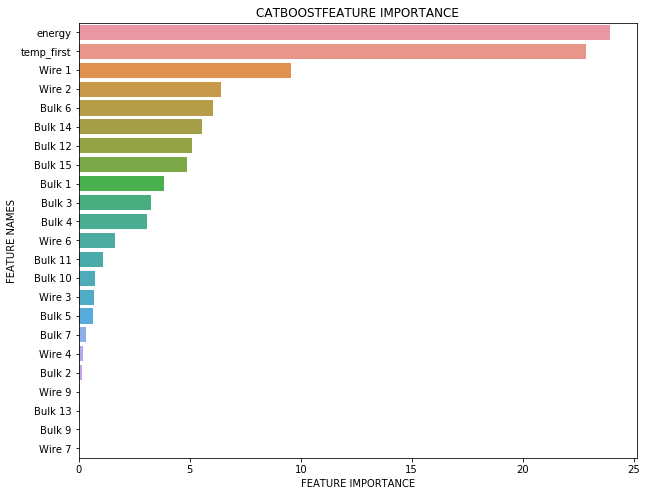

In [57]:
def plot_feature_importance(importance,names,model_type):

    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(model_CBR.get_feature_importance(),features_train.columns,'CATBOOST')

<div class="alert alert-info">
    
* По энергии и температуре вопросов нет, они действительно кажутся самыми важными
* С материалами интереснее: сыпучие 2, 7, 9 добавляются в больших количествах, судя по гистограммам выше, но на температуру почти не влияют
* Также заметил, что в признаки попал номер партии. Пришлось убрать, поэтому результаты немного поменялись
</div>

<div class="alert alert-info">
    
Николай, еще раз спасибо за помощь! 
    
Надеюсь на работе получится внедрить ML, у меня даже задача похожая...
    
</div>

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА 2</u></b>
</font>
<font color='green'><br>
Привет, Дмитрий. ОК с доработками, теперь можно сказать, что весь алгоритм применён при моделировании - от постановки проблематики до аналитики силы влияния фаткоров.<br>
Про кей - однозначно удалять. Видимо пропустил в прошлый раз, извини. Здорово, что сам увидел)<br>
 
Всегда стараюсь на этом проекте сказать всем вот ещё что: цель заказчика - экономия энергоресурсов.<br>
И в этом проекте искали как раз способ точно предсказывать температуру. И круто использовали для этого весь арсенал<br>
А если рассудать с позиции такой: а что нужно сделать, чтобы снизить энергопотребление?<br>
Судя по модели, самым важным фактором является первая температура. Это значит, что управляя ею, мы сможем управлять энергозатратами. Вывод понятен. Теперь надо разработать мероприятия для этого решения. И тут вопрос возникает скм собой: а это так точно? мы можем управлять первой температурой? В общем, наша модель - только начало работы над энергоэффективностью.<br>
    
Так же есть ещё одна идея, которую хотел предложить тебе на обсуждение.<br>
Возможно, покажется интересным<br><br> 

Дело касается принципиально иного подхода к поиску решения для снижения энергопотребления на производстве<br>
Смотри, Создание данной модели (таково было задание) двигалось по пути "угадывания" температуры<br>
Но мы же знаем жизнь)) лёгкие колебания температур (как и нашего настроения, нашего веса.....)<br>
есть всегда. Более того - будут вегда! И нам что, стараться угадывать их?<br>
Не угонимся, "пупок" развяжется))))) <br>
Предложу для подобных проектов подумать вот в какую сторону<br>
    
Итак, разброс в измерениях - есть, был и будет!! (т.к. этому благоприятствует разнообразие факторов самого проиозводства)<br>
    Тогда задачу можно поставить так: <u>надо уменьшить разброс в измерениях</u>. В данном случае в температуре.<br>
Один из подходов такой: Наверняка есть границы, в пределах которых колебания температур - дело нормальное.<br>
А что, если фикировать случаи, когда температура выходит за эти границы?<br>
Скажем, как "1". И тогда для таких моментов времени собирать инфо по производству: <br>
а что был за материал (химия материала), что был за газ (химический состав газа), какая бригада работала, <br>
что там было с электродами, ограничения только в фантазиях ну и в знаниях самого производства..... <br>
И вот тут можем реально находить причины (через корреляции, проверки гипотез, разные модельки...), фиксировать эти причины. <br>
Ну и разрабатывать энергосберегательные мероприятия.<br><br>
Успешного решения твоей задачи!<br> 
<font color='green'>

Спасибо за этот труд и за совместную работу на других проектах)<br>
Искренне желаю покорить ещё не один аналитический Эверест)
    </div>

## Общий вывод

* В предобработке пришлось избавиться от трех партий: отрицательная реактивная мощность, редкие сыпучая и проволочная присадка. В сумме меньше одного процента данных
* Данные в целом распределены нормально, но есть сильные бимодальные исключения
* По мультиколинеарности отвалился столбец `Wire 8`
* Логистическая регрессия дает МАЕ = 8.3
* Линейная регрессия дает МАЕ = 6.8
* Случайный лес с параметрами глубина-12 и деревья-120 дает МАЕ 6.5
* CatBoostRegressor дает МАЕ - 6.3 - лучший результат
* Глупые модели дают результат хуже - 8.6
* Цель по МАЕ <= 6.3 достигнута

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>
Дмитрий, скажу, что уверенная работа, на мой взгляд)<br>
Обработка данных, модельная работа, конечные результаты - многое удалось как надо<br> Очень здорово, что сразу ищешь новые фичи, думаешь над ними, анализируешь. Это тот самый подход, который нужен, чтобы искать ту саму модель для заказчика)<br> Осталось лишь несколько вопросов с моей стороны))<br>
   
При моделировании существует проблематика мультиколлинеарности.(когда количественные факторы модели имеют сильную корреляцию друг с другом - больше 0.8).Есть ли она у нас?  Если есть - надо  решать по понятиям:) - удалить лишнее. И ты это делаешь! Но есть ещё важный инструмент в нашей профессии, который нам помогает:<br><br>
<font color='red'>     
Попробуй с помощью команды feature_importances_ выводить график важности факторов. Отличная вещь будет: высока яметрика + график рейтинаг факторов по силе влияния на целевой признак). Важнейшая часть любого модельного финала.
Если видно, что часть факторов - слабозначимые для модели. Т.е. не значительно влияют на целевую переменную, то их смело можно убирать из модели. Ну и для бизнеса доносить: так мол и так - на эти факторы надо обращать внимание, а эти не влияют.<br>
    
<font color='green'>
<font color='green'>
Однозначно видно, что ты технически сделал хорошую работу.<br>
Осталось не много)<br>

Спасибо)<br>
БУДУ ЖДАТЬ КОММЕНТАРИЕВ.
    </div>

## Отчет о работе

Вопросы для отчета:
* Какие пункты плана были выполнены, а какие — нет (поясните почему)?
* Какие трудности возникли и как вы их преодолели?
* Какие ключевые шаги в решении задачи выделили?
* Какая ваша итоговая модель и какое у неё качество?

* Почти все пункты плана были выполнены. Не строил ящик с усами, т.к. хватило гистограмм плотности распределения. Дополнительно к плану рассмотрел модель градиентного бустинга catboost. Также добавил важность признаков, благодаря подсказке ревьюера
* Честно говоря, значительных трудностей не возникло во многом благодаря плану. Т.е. по порядку выполнил все действия и сразу добился нужного значения метрики. Подсматривал в предыдущие работы и конечно stackoverflow.
* Ключевых шага два: анализ и подготовка данных, моделирование. При подготовке сформировал таблицу с признаками, что позволило не возвращаться к данным, а сосредоточиться на моделях
* Итоговая модель градиентного бустинга CatBoostRegressor с глубиной 7 и МАЕ-6.3

Отчет для заказчика:
* В данных было одно отрицательное значение реактивной мощности, которое сильно выбивалось из распределения. Эту партию исключили из дальнейшего рассмотрения. Также были исключены партии с использованием `Bulk 8` и `Wire 5`, т.к. их всего две и они были определены как аномальные, т.е. очень редкие
* Анализ влияния параметров на конечную температуру показал, что наибольшее значение имеют энергия и начальная температра (что не вызывает удивления). Дальше по степени важности идут проволочные 1, 2 и сыпучие 14, 12, 15. Почти никакого влияния на конечную температуру не имеют проволочные 4, 9, 7 и сыпучие 7, 2, 13, 9
* Лучшая модель градиентного бустинга показала среднюю абсолютную ошибку по конечной температуре - 6.3 (наверное градусов цельсия)